Autores: Alexandre Liermann, Gustavo Guerreiro e João Martinho.

# Implementação de Classificação de Imagens de Ressonância Magnética para Diagnóstico de Alzheimer Usando CNN em TensorFlow

Importações das bibliotecas necessárias

In [12]:
import tensorflow as tf
import pathlib

Definindo os diretórios do dataset

In [ ]:
dir_dados = pathlib.Path('Dataset Alzheimer Sem Moderate')
dir_treino = dir_dados / 'train'
dir_teste = dir_dados / 'test'

Carregando os imagens automaticamente para o TensorFlow.

In [14]:
img_height = 176
img_width = 208
batch_size = 32

dataset_treino = tf.keras.utils.image_dataset_from_directory(
    dir_treino,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

dataset_teste = tf.keras.utils.image_dataset_from_directory(
    dir_teste,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

print('Classes encontradas:', dataset_treino.class_names)

Found 5121 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.
Classes encontradas: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


Normalizando a imagem para ficar mais natural para a CNN.

In [15]:
def normalizar_img(imagem, rotulo):
    imagem = tf.cast(imagem, tf.float32) / 255.0
    return imagem, rotulo

dataset_treino = dataset_treino.map(normalizar_img)
dataset_teste = dataset_teste.map(normalizar_img)

Configurando operações de cache e prefetch para aprimorar desempenho.

In [16]:
from tensorflow.data import AUTOTUNE

dataset_treino = dataset_treino.cache().shuffle(800).prefetch(buffer_size=AUTOTUNE)
dataset_teste = dataset_teste.cache().prefetch(buffer_size=AUTOTUNE)

Fazendo data augmentation.

In [17]:
# from tensorflow.keras import layers
#
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal"),
# ])
#
# dataset_treino = dataset_treino.map(lambda x, y: (data_augmentation(x, training=True), y))

Isolando luminância.

In [18]:
def isolar_luminancia(imagem, rotulo):
    imagem = tf.image.rgb_to_grayscale(imagem)
    return imagem, rotulo

dataset_treino = dataset_treino.map(isolar_luminancia)
dataset_teste = dataset_teste.map(isolar_luminancia)

Iniciando a configuração do modelo.

In [19]:
from tensorflow.keras import models, layers

modelo = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same',
                  input_shape=(img_height, img_width, 1)),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax'),
])



Compilando o modelo com a definição de otimizador (Adaptive Moment Estimation), perda e métricas.

In [20]:
modelo.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Definindo callback de EarlyStopping.

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

Treinando o modelo

In [22]:
history = modelo.fit(
    dataset_treino,
    validation_data=dataset_teste,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\ipykernel\kernelapp.py", line 758, in start

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\tornado\platform\asyncio.py", line 211, in start

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\asyncio\base_events.py", line 683, in run_forever

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\asyncio\base_events.py", line 2050, in _run_once

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\asyncio\events.py", line 89, in _run

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\ipykernel\kernelbase.py", line 614, in shell_main

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_shell

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\ipykernel\ipkernel.py", line 366, in execute_request

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\ipykernel\kernelbase.py", line 827, in execute_request

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\ipykernel\ipkernel.py", line 458, in do_execute

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\ipykernel\zmqshell.py", line 663, in run_cell

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\IPython\core\interactiveshell.py", line 3116, in run_cell

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\IPython\core\interactiveshell.py", line 3171, in _run_cell

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\IPython\core\interactiveshell.py", line 3394, in run_cell_async

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\IPython\core\interactiveshell.py", line 3639, in run_ast_nodes

  File "C:\Users\alexandre.liermann\AppData\Roaming\Python\Python313\site-packages\IPython\core\interactiveshell.py", line 3699, in run_code

  File "C:\Users\alexandre.liermann\AppData\Local\Temp\ipykernel_19700\2694244183.py", line 1, in <module>

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 399, in fit

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 241, in function

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 154, in multi_step_on_iterator

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 125, in wrapper

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 134, in one_step_on_data

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 62, in train_step

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\trainer.py", line 383, in _compute_loss

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\trainer.py", line 351, in compute_loss

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\compile_utils.py", line 699, in __call__

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\compile_utils.py", line 724, in call

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\losses\loss.py", line 67, in __call__

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\losses\losses.py", line 33, in call

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\losses\losses.py", line 2330, in sparse_categorical_crossentropy

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\ops\nn.py", line 2016, in sparse_categorical_crossentropy

  File "c:\Users\alexandre.liermann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 753, in sparse_categorical_crossentropy

Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 2 2 3 3 2 2 3 2 3 3 2 3 3 3 3 2 3 2 0 3 2 2 3 0 2 2 2 2 3 2 3 2
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_7114]

Avaliando os resultados do treino

In [ ]:
perda, acuracia = modelo.evaluate(dataset_teste)

print(f"Acurácia: {acuracia:.2f}")
print(f"Perda: {perda:.2f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5099 - loss: 0.9616
Acurácia: 0.51
Perda: 0.96


Métricas mais avançadas com sklearn

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

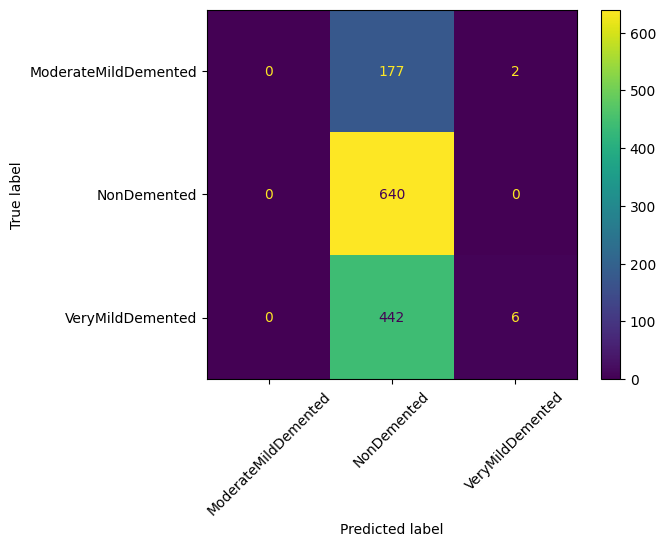

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from matplotlib import pyplot as plt

y_verdadeiro = []
y_previsto = []

for imagens, rotulos in dataset_teste:
    previsoes = modelo.predict(imagens)
    y_verdadeiro.extend(rotulos.numpy())
    y_previsto.extend(np.argmax(previsoes, axis=1))

classes = ['ModerateMildDemented', 'NonDemented', 'VeryMildDemented']
cm = confusion_matrix(y_verdadeiro, y_previsto)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.show()